In [2]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Ignorar advertencias menores para un output más limpio
warnings.filterwarnings('ignore')

# --- Carga del Dataset ---
# Asegúrate de que el archivo 'yellow_tripdata_2022-05.parquet' esté en el mismo directorio
# que el script, o proporciona la ruta completa.
print("Cargando el dataset...")
try:
    # Carga usando pyarrow (más eficiente para parquet)
    tripData = pq.read_table('yellow_tripdata_2022-05.parquet')

    # Conversión a DataFrame de Pandas
    df = tripData.to_pandas()
    print("Dataset cargado y convertido exitosamente.")

except FileNotFoundError:
    print("❌ ERROR: No se encontró el archivo 'yellow_tripdata_2022-05.parquet'.")
    print("Asegúrate de que la ruta del archivo sea correcta.")
    # Salir si el archivo no se encuentra
    exit()
except Exception as e:
    print(f"❌ ERROR al cargar o convertir el archivo: {e}")
    exit()

# Configuración de visualización
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")

print("\n--- Vista Preliminar y Estructura ---")
print("✅ Primeras 5 filas del DataFrame:")
print(df.head())

print("\n✅ Información general del DataFrame (tipos de datos, valores no nulos):")
df.info(verbose=False, memory_usage='deep')
# Muestra el número total de filas y columnas
print(f"\n✅ Dimensiones del DataFrame: {df.shape[0]} filas, {df.shape[1]} columnas")



Cargando el dataset...
Dataset cargado y convertido exitosamente.

--- Vista Preliminar y Estructura ---
✅ Primeras 5 filas del DataFrame:
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2022-05-01 00:00:36   2022-05-01 00:19:18              1.0   
1         1  2022-05-01 00:27:44   2022-05-01 00:41:33              1.0   
2         1  2022-05-01 00:59:00   2022-05-01 01:14:22              1.0   
3         1  2022-05-01 00:48:18   2022-05-01 01:28:02              1.0   
4         1  2022-05-01 00:28:26   2022-05-01 00:37:49              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0            4.1         1.0                  N           246           151   
1            2.3         1.0                  N           238            74   
2            4.2         1.0                  N           163           260   
3            0.0         1.0                  N            79           182   
4            1.

In [ ]:
#1. Resumen Estadístico
print("\n--- 1. Resumen Estadístico de Variables Numéricas ---")
# Resumen para variables numéricas (con un decimal para mejor lectura)
print(df.describe().T.round(1))

# Observaciones iniciales:
# - 'trip_distance' tiene un valor máximo muy alto, sugiriendo posibles atípicos (outliers).
# - 'fare_amount', 'tip_amount', 'tolls_amount' también tienen valores máximos elevados.
# - 'passenger_count' tiene un mínimo de 0, lo cual es inusual pero puede ser válido.




--- 1. Resumen Estadístico de Variables Numéricas ---
                           count                        mean  \
VendorID               3588295.0                    1.713103   
tpep_pickup_datetime     3588295  2022-05-16 07:50:29.219312   
tpep_dropoff_datetime    3588295  2022-05-16 08:08:42.275203   
passenger_count        3458771.0                    1.393923   
trip_distance          3588295.0                    6.856861   
RatecodeID             3458771.0                    1.365674   
PULocationID           3588295.0                  164.573797   
DOLocationID           3588295.0                  162.551711   
payment_type           3588295.0                    1.183209   
fare_amount            3588295.0                   15.168132   
extra                  3588295.0                    1.020728   
mta_tax                3588295.0                     0.48911   
tip_amount             3588295.0                    2.824744   
tolls_amount           3588295.0                 


--- 2. Detección de Valores Faltantes ---
✅ Conteo de valores faltantes por columna:
passenger_count         129524
RatecodeID              129524
store_and_fwd_flag      129524
congestion_surcharge    129524
airport_fee             129524
dtype: int64

✅ Porcentaje de valores faltantes:
passenger_count         3.61
RatecodeID              3.61
store_and_fwd_flag      3.61
congestion_surcharge    3.61
airport_fee             3.61
dtype: float64


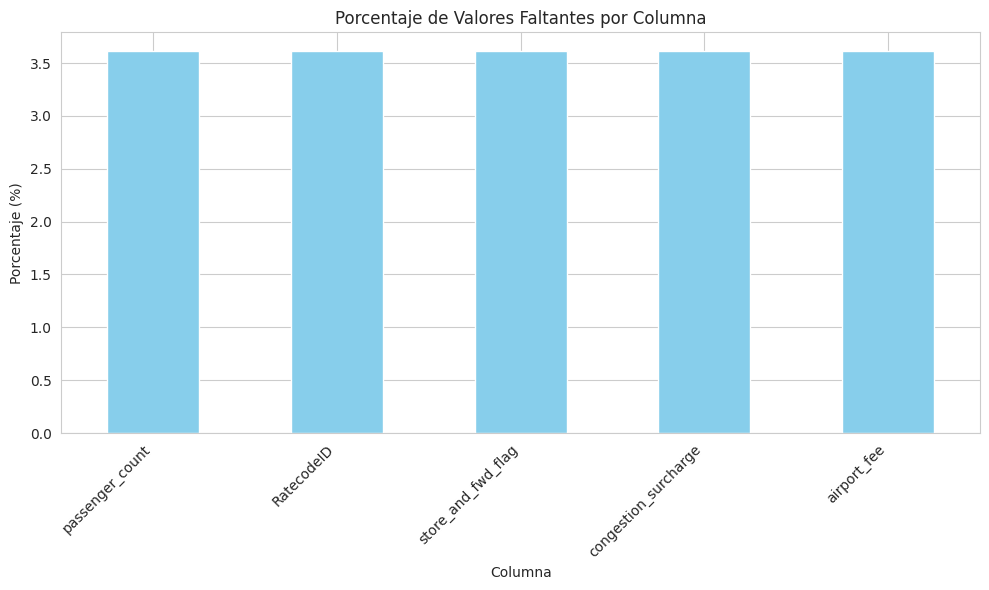

In [ ]:
#2. Detección de Valores Faltantes (Missing Data)
print("\n--- 2. Detección de Valores Faltantes ---")
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

if not missing_data.empty:
    print("✅ Conteo de valores faltantes por columna:")
    print(missing_data)

    # Calcula el porcentaje de valores faltantes
    missing_percentage = (missing_data / len(df)) * 100
    print("\n✅ Porcentaje de valores faltantes:")
    print(missing_percentage.round(2))

    # Visualización de valores faltantes (si los hay)
    plt.figure(figsize=(10, 6))
    missing_percentage.plot(kind='bar', color='skyblue')
    plt.title('Porcentaje de Valores Faltantes por Columna')
    plt.ylabel('Porcentaje (%)')
    plt.xlabel('Columna')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("✅ No se encontraron valores faltantes en el dataset.")




--- 3. Limpieza y Análisis de Variables Clave ---
Filas eliminadas por limpieza inicial: 264003
Dimensiones del DataFrame limpio: (3324292, 19)

✅ Conteo de pasajeros por viaje:
passenger_count
1.0    75.28
2.0    15.95
3.0     4.05
5.0     1.82
4.0     1.65
6.0     1.25
7.0     0.00
8.0     0.00
Name: proportion, dtype: float64


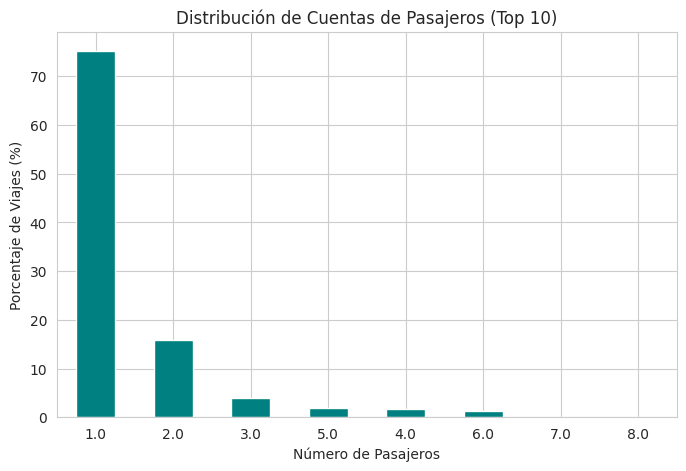

In [ ]:
#3. Limpieza y Análisis de Variables Clave
#Se aplica una limpieza básica para eliminar filas con valores claramente inválidos (por ejemplo, tarifas o distancias no positivas).
print("\n--- 3. Limpieza y Análisis de Variables Clave ---")

# Filtrado inicial para registros lógicos
df_clean = df[
    (df['trip_distance'] > 0) &
    (df['fare_amount'] > 0) &
    (df['passenger_count'] > 0)
].copy()

print(f"Filas eliminadas por limpieza inicial: {len(df) - len(df_clean)}")
print(f"Dimensiones del DataFrame limpio: {df_clean.shape}")

# Análisis de la variable 'passenger_count'
print("\n✅ Conteo de pasajeros por viaje:")
passenger_counts = df_clean['passenger_count'].value_counts(normalize=True).head(10) * 100
print(passenger_counts.round(2))

# Visualización de 'passenger_count'
plt.figure(figsize=(8, 5))
passenger_counts.plot(kind='bar', color='teal')
plt.title('Distribución de Cuentas de Pasajeros (Top 10)')
plt.xlabel('Número de Pasajeros')
plt.ylabel('Porcentaje de Viajes (%)')
plt.xticks(rotation=0)
plt.show()



--- 4. Análisis de Distribución (Distancia, Tarifa y Propina) ---


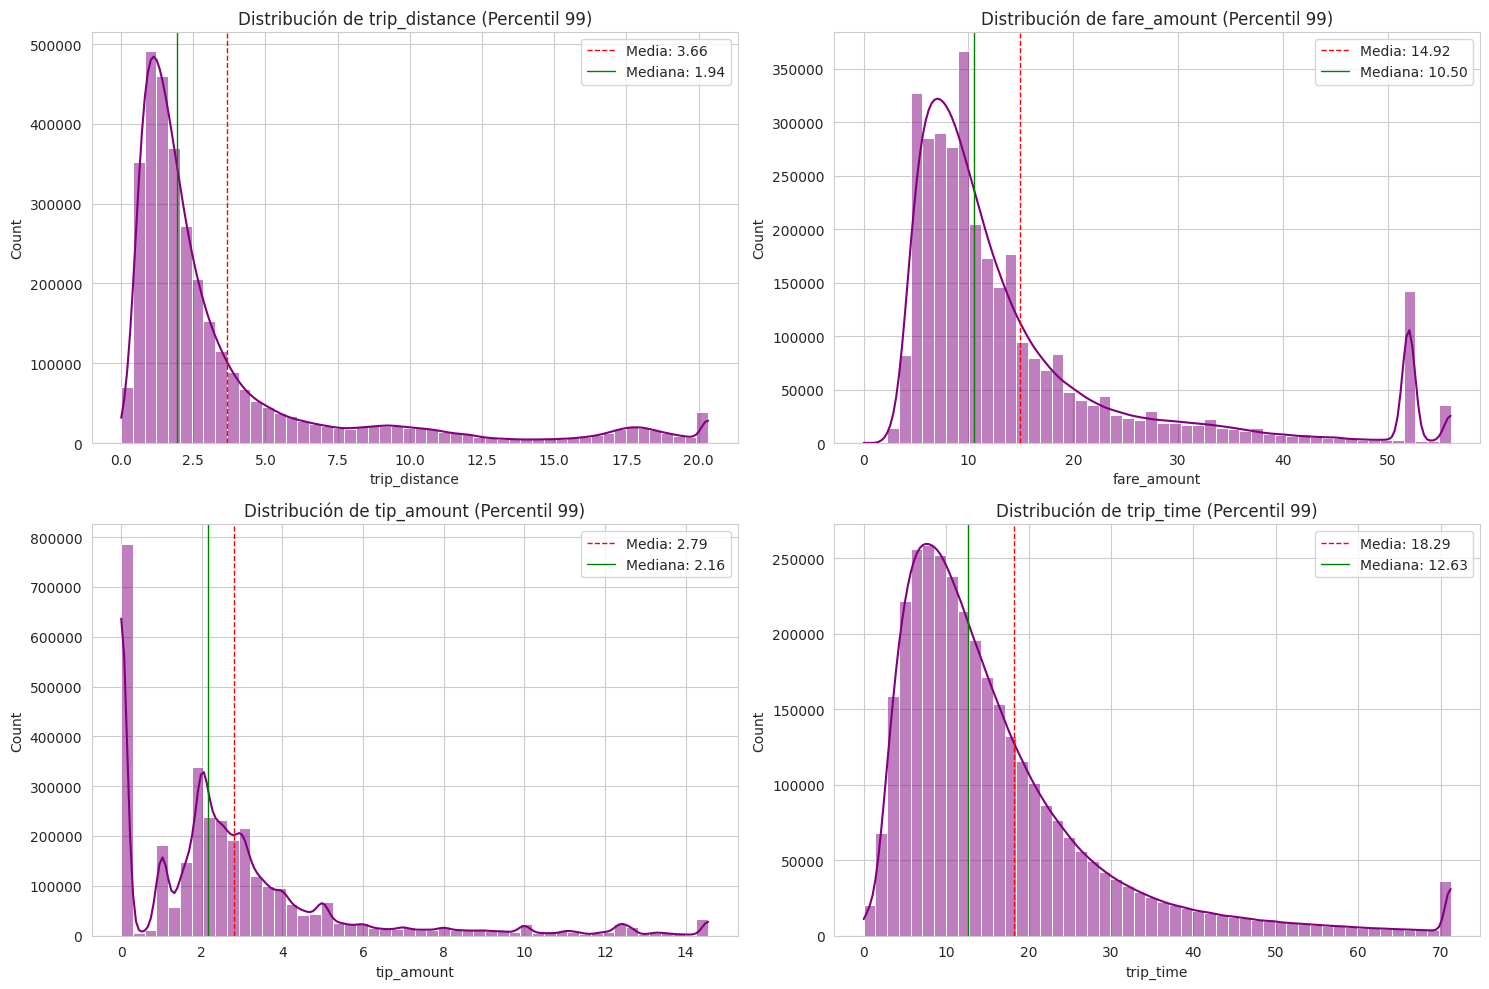

In [ ]:
#4. Análisis de Distribución de Variables Numéricas
#Visualización de las distribuciones para identificar la forma de los datos, la concentración y los valores atípicos.
print("\n--- 4. Análisis de Distribución (Distancia, Tarifa y Propina) ---")

# Creación de nuevas variables para el análisis
df_clean['trip_time'] = (df_clean['tpep_dropoff_datetime'] - df_clean['tpep_pickup_datetime']).dt.total_seconds() / 60
df_clean = df_clean[df_clean['trip_time'] > 0] # Eliminar viajes con tiempo <= 0

# Variables a visualizar
numeric_cols = ['trip_distance', 'fare_amount', 'tip_amount', 'trip_time']

# Detección de Outliers usando IQR (Interquartile Range) y Limitación para visualización
# Solo mostraremos las distribuciones de los datos sin valores extremos
def cap_outliers(series, lower_quantile=0.01, upper_quantile=0.99):
    """Limita los valores de una serie entre los percentiles especificados."""
    lower_bound = series.quantile(lower_quantile)
    upper_bound = series.quantile(upper_quantile)
    return np.clip(series, lower_bound, upper_bound)

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(2, 2, i + 1)

    # Aplicar limitación de outliers solo para la visualización (99th percentile)
    capped_data = cap_outliers(df_clean[col], 0.0, 0.99)

    sns.histplot(capped_data, bins=50, kde=True, color='purple')

    # Agregar la media y mediana al gráfico
    mean_val = df_clean[col].mean()
    median_val = df_clean[col].median()
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Media: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='solid', linewidth=1, label=f'Mediana: {median_val:.2f}')

    plt.title(f'Distribución de {col} (Percentil 99)', fontsize=12)
    plt.xlabel(col)
    plt.legend()

plt.tight_layout()
plt.show()

# Conclusiones de la distribución:
# - Todas las variables están altamente sesgadas a la derecha (right-skewed), con la mayoría de los viajes concentrados
#   en distancias, tarifas y tiempos bajos, indicando muchos viajes cortos.
# - La media es mayor que la mediana, confirmando el sesgo a la derecha.



--- 5. Análisis de Patrones Temporales ---


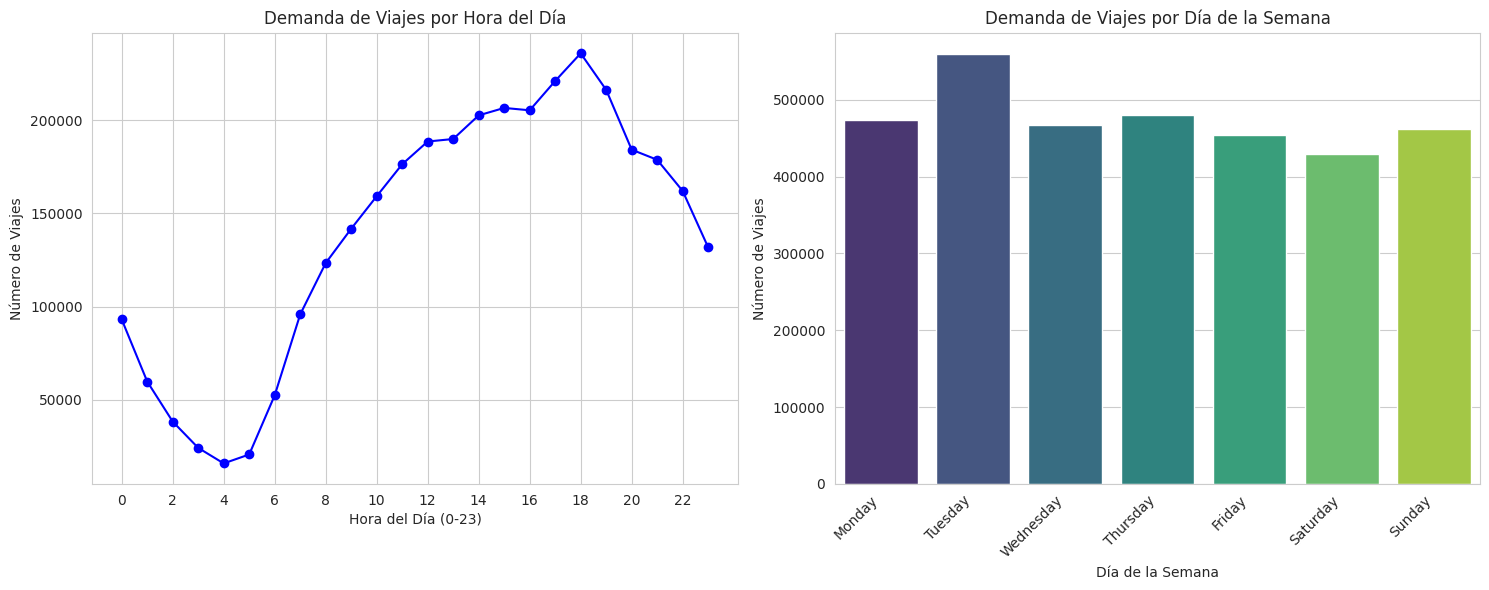

In [ ]:
#5. Análisis Temporal
#Análisis de la demanda de viajes por hora del día y día de la semana.
print("\n--- 5. Análisis de Patrones Temporales ---")

# Extraer hora y día de la semana
df_clean['pickup_hour'] = df_clean['tpep_pickup_datetime'].dt.hour
df_clean['day_of_week'] = df_clean['tpep_pickup_datetime'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(15, 6))

# Viajes por Hora del Día
plt.subplot(1, 2, 1)
hourly_demand = df_clean['pickup_hour'].value_counts().sort_index()
hourly_demand.plot(kind='line', marker='o', color='blue')
plt.title('Demanda de Viajes por Hora del Día')
plt.xlabel('Hora del Día (0-23)')
plt.ylabel('Número de Viajes')
plt.xticks(range(0, 24, 2))
plt.grid(True)

# Viajes por Día de la Semana
plt.subplot(1, 2, 2)
daily_demand = df_clean['day_of_week'].value_counts().reindex(day_order)
sns.barplot(x=daily_demand.index, y=daily_demand.values, palette="viridis")
plt.title('Demanda de Viajes por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Número de Viajes')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Conclusiones temporales:
# - La hora pico parece ser alrededor de la tarde-noche (ej. 17:00 - 19:00).
# - Los días de mayor actividad son los laborables (lunes a viernes).




--- 6. Análisis de Correlación ---


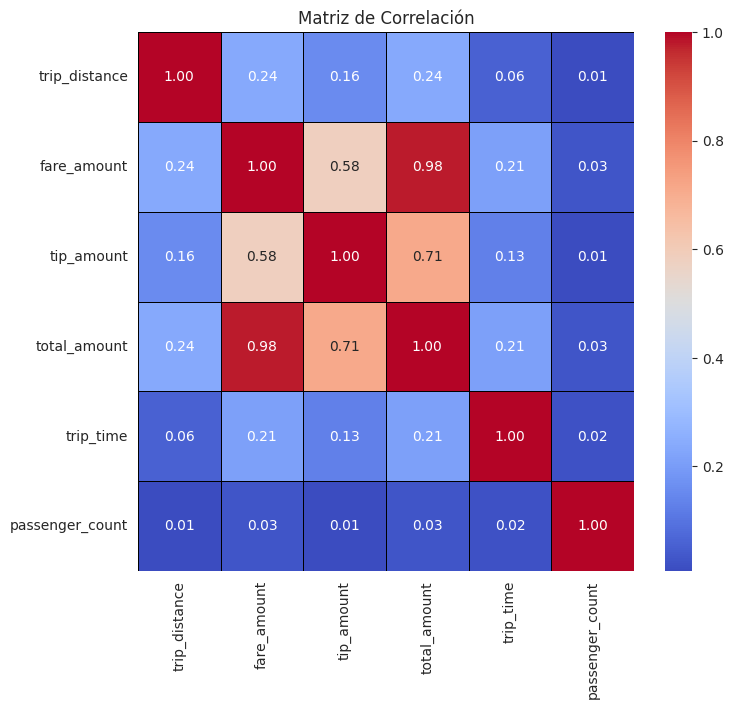

In [ ]:
#6. Análisis de Correlación
#Visualización de la matriz de correlación para entender la relación lineal entre las variables numéricas.
print("\n--- 6. Análisis de Correlación ---")

# Selección de variables relevantes para la correlación
corr_cols = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'trip_time', 'passenger_count']
correlation_matrix = df_clean[corr_cols].corr()

plt.figure(figsize=(8, 7))
sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            cbar=True,
            linewidths=.5,
            linecolor='black')
plt.title('Matriz de Correlación')
plt.show()

# Conclusiones de Correlación:
# - **Correlación Fuerte:** Existe una correlación muy fuerte entre 'trip_distance', 'fare_amount' y 'total_amount'
#   (como se esperaba, ya que la tarifa depende de la distancia).
# - 'trip_time' también está fuertemente correlacionado con la distancia/tarifa.
# - 'tip_amount' tiene una correlación moderada con la tarifa y la distancia, indicando que las propinas aumentan
#   ligeramente con viajes más caros/largos.
# - 'passenger_count' muestra una correlación muy baja con el resto de variables.
